# 2D Log-Gaussian Cox Process via Spatio-Temporal Kalman Smoothing

## Import and load data

rainforest data loaded


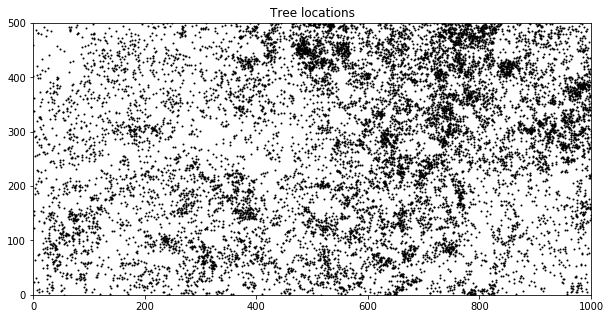

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, discretegrid

plot_intermediate = False

data = np.loadtxt('../../data/TRI2TU-data.csv', delimiter=',')

nr = 100  # spatial grid point (y-aixs)
nt = 200  # temporal grid points (x-axis)
scale = 1000 / nt

t, r, Y = discretegrid(data, [0, 1000, 0, 500], [nt, nr])

np.random.seed(99)
N = nr * nt  # number of data points
print('rainforest data loaded')

plt.figure(1, figsize=(10, 5))
plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
plt.title('Tree locations')
plt.xlim(0, 1000)
plt.ylim(0, 500);

## Build the GP model

In [2]:
var_f = 1  # GP variance
len_f = 10  # lengthscale

prior = priors.SpatialMatern32(variance=var_f, lengthscale=len_f, z=r[0, ...], fixed_grid=True)
lik = likelihoods.Poisson()
inf_method = approx_inf.ExtendedKalmanSmoother(damping=0.5)
# inf_method = approx_inf.ExtendedEP()

model = SDEGP(prior=prior, likelihood=lik, t=t, y=Y, r=r, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Spatial Matern-3/2 prior and Poisson likelihood ...
inference method is Extended Kalman Smoother (EKS)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=2e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 5) == 0:
        print('iter %2d: var=%1.2f len=%1.2f, nlml=%2.2f' %
              (i, prior_params[0], prior_params[1], neg_log_marg_lik))

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(50):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var=1.00 len=10.00, nlml=25473.41
iter  5: var=0.98 len=10.99, nlml=24866.37
iter 10: var=1.42 len=11.95, nlml=24804.02
iter 15: var=1.58 len=12.86, nlml=24779.10
iter 20: var=1.42 len=13.67, nlml=24692.80
iter 25: var=1.23 len=14.40, nlml=24617.45
iter 30: var=1.21 len=15.02, nlml=24576.84
iter 35: var=1.31 len=15.56, nlml=24566.41
iter 40: var=1.36 len=16.01, nlml=24567.53
iter 45: var=1.32 len=16.39, nlml=24558.20
optimisation time: 261.67 secs


## Make predictions

In [5]:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
# nlpd = model.negative_log_predictive_density(t=t, r=r, y=Y)
mu, var = model.predict(t=t, r=r)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

calculating the posterior predictive distribution ...
prediction time: 5.02 secs


## Plot the posterior mean

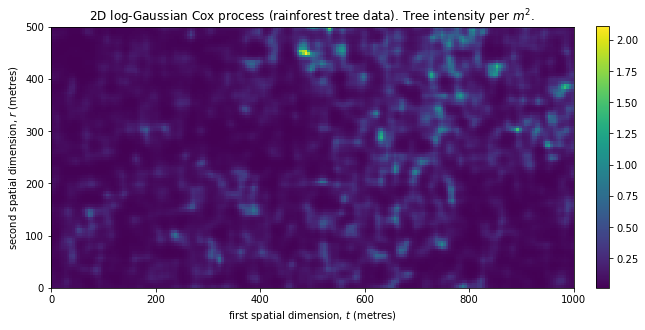

In [6]:
link_fn = model.likelihood.link_fn
plt.figure(2, figsize=(10, 5))
# im = plt.imshow(mu.T, extent=[0, 1000, 0, 500], origin='lower')
im = plt.imshow(link_fn(mu).T / scale, extent=[0, 1000, 0, 500], origin='lower')
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.xlim(0, 1000)
plt.ylim(0, 500)
# plt.title('2D log-Gaussian Cox process (rainforest tree data). Log-intensity shown.')
plt.title('2D log-Gaussian Cox process (rainforest tree data). Tree intensity per $m^2$.')
plt.xlabel('first spatial dimension, $t$ (metres)')
plt.ylabel('second spatial dimension, $r$ (metres)');